In [1]:
import json
import pandas as pd

In [16]:
import numpy as np
import matplotlib.pyplot as plt

In [28]:
import os

In [8]:
!ls data/results/

post-acceptance-1.tsv results-1-final.tsv   results-2-final.tsv


In [9]:
df_1 = pd.read_csv('data/results/results-1-final.tsv', sep='\t')
df_2 = pd.read_csv('data/results/results-2-final.tsv', sep='\t')
df = pd.concat([df_1, df_2])

In [10]:
len(df)

325

In [11]:
df.head(1)

,INPUT:id,INPUT:url,INPUT:name,INPUT:text,INPUT:title,OUTPUT:no_per,OUTPUT:result,GOLDEN:no_per,GOLDEN:result,HINT:text,HINT:default_language,ASSIGNMENT:task_id,ASSIGNMENT:assignment_id,ASSIGNMENT:worker_id,ASSIGNMENT:status,ACCEPT:verdict,ACCEPT:comment
0,9,https://ru.wikisource.org/wiki/Война_и_мир_(То...,Князь Василий Курагин,"И он с теми свободными и фамильярными, грациоз...",Война и мир,NaN,"{""label"":""pro""\,""offset"":2\,""length"":2\,""segme...",NaN,NaN,NaN,NaN,0002427d51--63f9e6a26e98d13e2ac08bc3,0002427d51--63fa06848b2e143ff7e92ea1,5e7d747e7586f521ad660369d9c84a79,APPROVED,+,NaN


In [12]:
df['ASSIGNMENT:status'].value_counts()

SUBMITTED    290
APPROVED      35
Name: ASSIGNMENT:status, dtype: int64

In [15]:
df['OUTPUT:no_per'].value_counts()

True    2
Name: OUTPUT:no_per, dtype: int64

In [18]:
lens = []
annotations = []
for _, row in df.iterrows():
    if not pd.isna(row['OUTPUT:result']):
        annotation = json.loads('[' + row['OUTPUT:result'].replace('\\', '') + ']')
        lens.append(len(annotation))
        annotations.append(annotation)
    else:
        lens.append(0)
        annotations.append([])

In [20]:
lens = np.array(lens)
print(max(lens), np.mean(lens))

25 7.009230769230769


In [21]:
np.bincount(lens)

array([ 2, 23, 38, 29, 26, 23, 20, 28, 25, 22, 15, 18, 18, 10,  8,  6,  1,
        3,  6,  1,  1,  0,  0,  0,  1,  1])

(array([ 2., 23., 38., 29., 26., 23., 20., 28., 25., 22., 15., 18., 18.,
        10.,  8.,  6.,  1.,  3.,  6.,  1.,  1.,  0.,  0.,  0.,  1.,  1.]),
 array([ 0.        ,  0.96153846,  1.92307692,  2.88461538,  3.84615385,
         4.80769231,  5.76923077,  6.73076923,  7.69230769,  8.65384615,
         9.61538462, 10.57692308, 11.53846154, 12.5       , 13.46153846,
        14.42307692, 15.38461538, 16.34615385, 17.30769231, 18.26923077,
        19.23076923, 20.19230769, 21.15384615, 22.11538462, 23.07692308,
        24.03846154, 25.        ]),
 <BarContainer object of 26 artists>)

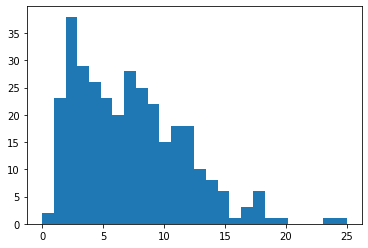

In [23]:
plt.hist(lens, bins=26)

In [24]:
sum(lens)

2278

In [25]:
np.median(lens)

7.0

In [26]:
groups = df.groupby('INPUT:title')

In [27]:
!pwd

/Users/zero/russian-lit


In [29]:
os.makedirs('brat-1.3p1/data/evaluation')

In [30]:
PATH = 'brat-1.3p1/data/evaluation'

In [31]:
rng = np.random.default_rng()

In [32]:
symbols = (u"абвгдеёжзийклмнопрстуфхцчшщъыьэюяАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ",
           u"abvgdeejzijklmnoprstufhzcss_y_euaABVGDEEJZIJKLMNOPRSTUFHZCSS_Y_EUA")
tr = {ord(a):ord(b) for a, b in zip(*symbols)}

In [53]:
rng = np.random.default_rng(31)
rng.choice(range(len(group)), size=2, replace=False)

array([19, 11])

In [62]:
rng = np.random.default_rng(31)
for name, group in groups:
    group = group.sort_values('INPUT:id', axis=0)
    to_eval = rng.choice(range(len(group)), size=2, replace=False)
    for ind in to_eval:
        row = group.iloc[ind]
        with open(os.path.join(PATH, name.translate(tr).replace(' ', '_').lower() + str(ind) + '.txt'), 'w') as f:
            f.write(row['INPUT:text'])
        annotations = json.loads('[' + row['OUTPUT:result'].replace('\\', '') + ']')
        cur_mention = 0
        print(ind, row['INPUT:name'])
        with open(os.path.join(PATH, name.translate(tr).replace(' ', '_').lower() + str(ind) + '.ann'), 'w') as f:
            for annotation in annotations:
                start = annotation['offset']
                end = annotation['offset']+annotation['length']
                mention = row['INPUT:text'][start:end]
                if annotation['label'] == 'per':
                    f.write('\t'.join([f'T{cur_mention}', f'PROP_PER {start} {end}', mention]))
                elif annotation['label'] == 'per_oblique':
                    f.write('\t'.join([f'T{cur_mention}', f'NOM_PER {start} {end}', mention]))
                elif annotation['label'] == 'pro':
                    f.write('\t'.join([f'T{cur_mention}', f'PRON_PER {start} {end}', mention]))
                f.write('\n')
                cur_mention += 1

36 Мадам Кузнецова
21 Молодой мужчина в пиджаке
1 Облонская, Дарья Александровна (Долли), жена Степана Аркадьевича
12 Матвей, камердинер Степана Аркадьевича Облонского
11 Елена Васильевна Курагина, дочь князя Василия Курагина
1 Князь Василий Курагин
24 Княжна Мери, дочь княгини Лиговской
23 княгиня Лиговская
6 Катерина Львовна Измайлова
1 Катерина Львовна Измайлова
9 Поэт Иван Николаевич Понырев (Бездомный)
49 Воланд ("иностранец", "неизвестный")
11 Захар, слуга Обломова
21 Илья Ильич Обломов
15 Мария Кирсанова, жена Николая Петровича Кирсанова
22 Евгений Васильевич Базаров
16 Алёна Ивановна, старуха-процентщица
1 Родион Раскольников
5 Пес Шарик
4 Пес Шарик


In [64]:
df['ASSIGNMENT:task_id'].nunique()

325

In [67]:
np.sort(lens)[-20:]

array([15, 15, 15, 15, 15, 15, 16, 17, 17, 17, 18, 18, 18, 18, 18, 18, 19,
       20, 24, 25])

In [72]:
sum(np.sort(lens)[-20:])

353

In [73]:
337 + 16

353

In [68]:
np.argsort(lens)[-20:]

array([250,  26, 314, 274, 288, 178,  75, 126, 169, 132, 228,  52, 172,
       131, 241,  51,  65, 321,   1, 175])

In [71]:
for ind in np.argsort(lens)[-20:]:
    row = df.iloc[ind]
    with open(os.path.join(
        PATH, row['INPUT:title'].translate(tr).replace(' ', '_').lower() + '_' + 'max' + '_' + str(ind) + '.txt'), 
              'w') as f:
        f.write(row['INPUT:text'])
    annotations = json.loads('[' + row['OUTPUT:result'].replace('\\', '') + ']')
    cur_mention = 0
    print(ind, row['INPUT:name'])
    with open(os.path.join(PATH, row['INPUT:title'].translate(tr).replace(' ', '_').lower() + '_' + 'max' + '_' + str(ind) + '.ann'), 'w') as f:
        for annotation in annotations:
            start = annotation['offset']
            end = annotation['offset']+annotation['length']
            mention = row['INPUT:text'][start:end]
            if annotation['label'] == 'per':
                f.write('\t'.join([f'T{cur_mention}', f'PROP_PER {start} {end}', mention]))
            elif annotation['label'] == 'per_oblique':
                f.write('\t'.join([f'T{cur_mention}', f'NOM_PER {start} {end}', mention]))
            elif annotation['label'] == 'pro':
                f.write('\t'.join([f'T{cur_mention}', f'PRON_PER {start} {end}', mention]))
            f.write('\n')
            cur_mention += 1

250 Захар, слуга Обломова
26 Николай Петрович Кирсанов
314 Катерина Львовна Измайлова
274 Филипп Филиппович Преображенский 
288 Катерина Львовна Измайлова
178 Воланд ("иностранец", "неизвестный")
75 Грушницкий
126 Николай Петрович Кирсанов
169 Воланд ("иностранец", "неизвестный")
132 Михаил Александрович Берлиоз
228 Воланд ("иностранец", "неизвестный")
52 Князь Василий Курагин
172 Поэт Иван Николаевич Понырев (Бездомный)
131 Анна Павловна Шерер
241 Захар, слуга Обломова
51 Грушницкий
65 Родион Раскольников
321 Катерина Львовна Измайлова
1 Степан Аркадьевич Облонский
175 Воланд ("иностранец", "неизвестный")


In [75]:
annotations = []
for _, row in df.iterrows():
    if not pd.isna(row['OUTPUT:result']) and row['ASSIGNMENT:status'] != 'REJECTED':
        annotations.extend(json.loads('[' + row['OUTPUT:result'].replace('\\', '') + ']'))

In [82]:
annotations[:5]

[{'label': 'pro', 'offset': 2, 'length': 2, 'segment': 'он'},
 {'label': 'pro', 'offset': 71, 'length': 3, 'segment': 'его'},
 {'label': 'pro', 'offset': 349, 'length': 5, 'segment': 'вашем'},
 {'label': 'per', 'offset': 9, 'length': 15, 'segment': 'Степан Аркадьич'},
 {'label': 'per_oblique',
  'offset': 29,
  'length': 17,
  'segment': 'человек правдивый'}]

In [79]:
from collections import Counter

In [80]:
c = Counter([ann['label'] for ann in annotations])

In [81]:
c.most_common()

[('pro', 1240), ('per', 572), ('per_oblique', 466)]

In [86]:
s = 1240 + 572 + 466

In [87]:
572 / s

0.2510974539069359

In [88]:
466 / s

0.20456540825285338

In [89]:
1240 / s

0.5443371378402108

In [90]:
import crowdkit

In [91]:
!ls data/results

n_mentions_distr.png  results-1-final.tsv
post-acceptance-1.tsv results-2-final.tsv


In [92]:
post_acc_df = pd.read_csv('data/results/post-acceptance-1.tsv', sep='\t')

In [93]:
post_acc_df.head()

,INPUT:id,INPUT:url,INPUT:name,INPUT:text,INPUT:title,INPUT:no_per,INPUT:input_data,INPUT:assignment_id,OUTPUT:path,OUTPUT:no_per,OUTPUT:result,GOLDEN:path,GOLDEN:no_per,GOLDEN:result,HINT:text,HINT:default_language,ASSIGNMENT:task_id,ASSIGNMENT:assignment_id,ASSIGNMENT:worker_id,ASSIGNMENT:status
0,8,https://ru.wikisource.org/wiki/Война_и_мир_(То...,"княжна Мария Болконская, дочь князя Николая Бо...","- Вы никогда не думали о том, чтобы женить ваш...",Война и мир,NaN,"{""label"":""per_oblique""\,""offset"":194\,""length""...",0002427d51--63faf5a77cf67476618899b2,yes,NaN,"{""label"":""per_oblique""\,""offset"":194\,""length""...",NaN,NaN,NaN,NaN,NaN,000243b124--6400ae00882f737fd76437fe,000243b124--6400b2456775a424fdfd9ad7,2372f0cd068c72b466e2b2e7a80a5617,APPROVED
1,5,https://ilibrary.ru/text/69/p.1/index.html,Родион Раскольников,"Он был до того худо одет, что иной, даже и при...",Преступление и наказание,NaN,"{""label"":""pro""\,""offset"":0\,""length"":2\,""segme...",0002427d51--63fa10b0870fa13968983811,yes,NaN,"{""label"":""pro""\,""offset"":0\,""length"":2\,""segme...",NaN,NaN,NaN,NaN,NaN,000243b124--6400ade0882f737fd76436d5,000243b124--6400b2456775a424fdfd9ad7,2372f0cd068c72b466e2b2e7a80a5617,APPROVED
2,14,https://ilibrary.ru/text/69/p.1/index.html,Родион Раскольников,"Оглядевшись, он заметил, что стоит подле распи...",Преступление и наказание,NaN,"{""label"":""pro""\,""offset"":13\,""length"":2\,""segm...",0002427d51--63fae9d03d101946d968c4b4,yes,NaN,"{""label"":""pro""\,""offset"":13\,""length"":2\,""segm...",no,NaN,"{""label"":""pro""\,""offset"":13\,""length"":2\,""segm...",NaN,NaN,000243b124--6400a0f39b50e141bf1fb4b5,000243b124--6400b2456775a424fdfd9ad7,2372f0cd068c72b466e2b2e7a80a5617,APPROVED
3,6,https://ru.wikisource.org/wiki/Война_и_мир_(То...,Князь Василий Курагин,- Барон Функе рекомендован императрице-матери ...,Война и мир,NaN,"{""label"":""per_oblique""\,""offset"":467\,""length""...",0002427d51--63fa83ae7658a9695759745a,yes,NaN,"{""label"":""per_oblique""\,""offset"":467\,""length""...",NaN,NaN,NaN,NaN,NaN,000243b124--6400adeb882f737fd7643731,000243b124--6400b2456775a424fdfd9ad7,2372f0cd068c72b466e2b2e7a80a5617,APPROVED
4,9,https://ilibrary.ru/text/12/p.6/index.html,княгиня Лиговская,"— Вот княгиня Лиговская, — сказал Грушницкий, ...",Герой нашего времени,NaN,"{""label"":""per""\,""offset"":6\,""length"":17\,""segm...",0002427d51--63fa0d9e945d675713333d3d,no,NaN,"{""label"":""per""\,""offset"":6\,""length"":17\,""segm...",NaN,NaN,NaN,NaN,NaN,000243b124--6400adde882f737fd76436c6,000243b124--6400b2e44289857a3fec4ed7,2372f0cd068c72b466e2b2e7a80a5617,APPROVED


In [94]:
post_acc_df['OUTPUT:path'].value_counts()

yes    303
no     187
Name: OUTPUT:path, dtype: int64

In [96]:
from crowdkit.aggregation import MajorityVote

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [101]:
post_acc_mv = post_acc_df[['ASSIGNMENT:task_id', 'ASSIGNMENT:worker_id', 'OUTPUT:path']].rename(
{'ASSIGNMENT:task_id': 'task', 'ASSIGNMENT:worker_id': 'worker', 'OUTPUT:path': 'label'}, axis=1)

In [102]:
result = MajorityVote().fit_predict(post_acc_mv)

In [104]:
result.value_counts()

yes    90
no     58
Name: agg_label, dtype: int64

In [105]:
from crowdkit.metrics.data._classification import alpha_krippendorff

In [106]:
alpha_krippendorff(post_acc_mv)

0.18817881788178814

In [108]:
MajorityVote().fit_predict_proba(post_acc_mv)

label,no,yes
task,,
000243b124--6400a0f39b50e141bf1fb47e,0.500000,0.500000
000243b124--6400a0f39b50e141bf1fb48f,0.500000,0.500000
000243b124--6400a0f39b50e141bf1fb49e,0.500000,0.500000
000243b124--6400a0f39b50e141bf1fb4b5,0.500000,0.500000
000243b124--6400a0f49b50e141bf1fb4c7,0.000000,1.000000
...,...,...
000243b124--6400ae03882f737fd764383b,0.000000,1.000000
000243b124--6400ae03882f737fd764383f,0.666667,0.333333
000243b124--6400ae03882f737fd7643842,0.000000,1.000000


In [110]:
np.argsort(lens)[-20:]

array([250,  26, 314, 274, 288, 178,  75, 126, 169, 132, 228,  52, 172,
       131, 241,  51,  65, 321,   1, 175])

In [115]:
df.keys()

Index(['INPUT:id', 'INPUT:url', 'INPUT:name', 'INPUT:text', 'INPUT:title',
       'OUTPUT:no_per', 'OUTPUT:result', 'GOLDEN:no_per', 'GOLDEN:result',
       'HINT:text', 'HINT:default_language', 'ASSIGNMENT:task_id',
       'ASSIGNMENT:assignment_id', 'ASSIGNMENT:worker_id', 'ASSIGNMENT:status',
       'ACCEPT:verdict', 'ACCEPT:comment'],
      dtype='object')

In [118]:
df.iloc[np.argsort(lens)[-20:]][['INPUT:id', 'INPUT:url', 'INPUT:name', 'INPUT:text', 'INPUT:title']].to_csv(
    'data/for labeling/tasks_max_mentions.tsv', sep='\t', index=False)

In [122]:
rng = np.random.default_rng(31)
random_tasks = []
for name, group in groups:
    group = group.sort_values('INPUT:id', axis=0)
    to_eval = rng.choice(range(len(group)), size=2, replace=False)
    for ind in to_eval:
        random_tasks.append(group.iloc[ind])
        print(ind)
random_tasks = pd.DataFrame(random_tasks)

36
21
1
12
11
1
24
23
6
1
9
49
11
21
15
22
16
1
5
4


In [124]:
random_tasks.head()

,INPUT:id,INPUT:url,INPUT:name,INPUT:text,INPUT:title,OUTPUT:no_per,OUTPUT:result,GOLDEN:no_per,GOLDEN:result,HINT:text,HINT:default_language,ASSIGNMENT:task_id,ASSIGNMENT:assignment_id,ASSIGNMENT:worker_id,ASSIGNMENT:status,ACCEPT:verdict,ACCEPT:comment
85,17,https://онлайн-читать.рф/ильф-и-петров-12-стул...,Мадам Кузнецова,Трое владельцев «Нимфы» стояли у своего заведе...,12 стульев,NaN,"{""label"":""per_oblique""\,""offset"":1327\,""length...",NaN,NaN,NaN,NaN,00024333bf--63fe1cee6224c16e7bafeb75,00024333bf--63fe34dbf6b08649eab1078f,6f3b3bc5d0ee3f0960869e4e10c6030b,SUBMITTED,NaN,NaN
69,9,https://онлайн-читать.рф/ильф-и-петров-12-стул...,Молодой мужчина в пиджаке,"– Товарищ, – сказала она, – где тут… Мужчина в...",12 стульев,NaN,"{""label"":""per_oblique""\,""offset"":37\,""length"":...",NaN,NaN,NaN,NaN,00024333bf--63fe1ce96224c16e7bafeb23,00024333bf--63fe324e09277532882442a9,6f3b3bc5d0ee3f0960869e4e10c6030b,SUBMITTED,NaN,NaN
103,1,https://ilibrary.ru/text/1099/p.1/index.html,"Облонская, Дарья Александровна (Долли), жена С...",Глава 1\r\nВсе счастливые семьи похожи друг на...,Анна Каренина,NaN,"{""label"":""per_oblique""\,""offset"":134\,""length""...",NaN,NaN,NaN,NaN,0002427d51--63f9e6a36e98d13e2ac08bee,0002427d51--63faf20ab332d532740ff6e7,a6d1f870109769c9e645946e54e131a9,SUBMITTED,NaN,NaN
83,7,https://ilibrary.ru/text/1099/p.2/index.html,"Матвей, камердинер Степана Аркадьевича Облонского","«Там видно будет», — сказал себе Степан Аркадь...",Анна Каренина,NaN,"{""label"":""per_oblique""\,""offset"":332\,""length""...",NaN,NaN,NaN,NaN,0002427d51--63f9e6a76e98d13e2ac08c54,0002427d51--63fadc425628fb352233c28f,7ff96ef3e1e2a514706289af5c3a5288,SUBMITTED,NaN,NaN
117,6,NaN,"Елена Васильевна Курагина, дочь князя Василия ...",- Барон Функе рекомендован императрице-матери ...,Война и мир,NaN,"{""label"":""per_oblique""\,""offset"":767\,""length""...",NaN,NaN,NaN,NaN,0002427d51--63f9e69f6e98d13e2ac08b54,0002427d51--63faf581bcb5d37e2adbefb0,a6d1f870109769c9e645946e54e131a9,SUBMITTED,NaN,NaN


In [125]:
random_tasks[['INPUT:id', 'INPUT:url', 'INPUT:name', 'INPUT:text', 'INPUT:title']].to_csv(
    'data/for labeling/tasks_random.tsv', sep='\t', index=False)

In [126]:
for name, group in groups:
    cur_mention = 0
    group = group.sort_values('INPUT:id', axis=0)
    fulltext = '\r\n'.join(group.sort_values('INPUT:id', axis=0)['INPUT:text'].unique())
    offsets = []
    with open(os.path.join('brat-1.3p1', 'data', name.translate(tr).replace(' ', '_').lower() + '.ann'), 'w') as f:
        for ind, subgroup in group.groupby('INPUT:id'):
            if not offsets:
                cur_offset = 0
            else:
                cur_offset = offsets[-1]
            par_annotations = []
            for _, row in subgroup.iterrows():
                if not pd.isna(row['OUTPUT:result']) and row['ASSIGNMENT:status'] != 'REJECTED':
                    par_annotations.extend(json.loads('[' + row['OUTPUT:result'].replace('\\', '') + ']'))
            par_annotations = sorted(par_annotations, key=lambda x: x['offset'])
            for annotation in par_annotations:
                start = cur_offset+annotation['offset']
                end = cur_offset+annotation['offset']+annotation['length']
                text = fulltext[start:end]
                if annotation['label'] == 'per':
                    f.write('\t'.join([f'T{cur_mention}', f'PROP_PER {start} {end}', text]))
                elif annotation['label'] == 'per_oblique':
                    f.write('\t'.join([f'T{cur_mention}', f'NOM_PER {start} {end}', text]))
                elif annotation['label'] == 'pro':
                    f.write('\t'.join([f'T{cur_mention}', f'PRON_PER {start} {end}', text]))
                f.write('\n')
                cur_mention += 1
            offsets.append(len(row['INPUT:text'])+cur_offset+2)

In [128]:
df['ASSIGNMENT:worker_id'].nunique()

22

In [129]:
df['ASSIGNMENT:worker_id'].value_counts()

e5f81efb44c1a1d5f2cfd192027a8417    115
88d4ae2462e6e7c1ff2ffda67c0169be     43
7ff96ef3e1e2a514706289af5c3a5288     30
6f3b3bc5d0ee3f0960869e4e10c6030b     27
4d9d450e2a627af9c3781e165434d355     21
3e58ff9879333efb981f792b2d109bab     19
a6d1f870109769c9e645946e54e131a9     17
f3cf3f9bb709ce2bee3da304a4ccb427     10
65b12e4e69a7d9aa50afd3595e805c61      9
a1e620b85542c283f46607e1a88d5bdb      7
4f84f6383f70e80851d2a643e222e206      4
696c9600713a5044e12f791d25012c5f      4
721ce40d924d355c0718a4fc724f4d98      3
ddffd2323733538d1322c4da0449f0e9      3
46f74bf71e87693862d6d876019e8d90      3
f03e577ce982366ce7f17432841db0b0      2
12999c48a3ce978108a3d956098854f6      2
20e1a1309cf5cfe58addb82192962773      2
2c0c3b72eb633e11f90f03e22c00e9ed      1
8133925c86f8a3a1cfe9dca5db2f5cee      1
17ade270184d61a940f7107da74cf70d      1
5e7d747e7586f521ad660369d9c84a79      1
Name: ASSIGNMENT:worker_id, dtype: int64